In [1]:
import pandas as pd 
import numpy as np
from numpy.linalg import 
import matplotlib.pyplot as plt

## program design

#### 1) input: CSV table with first coloumn market
#### 2) intermediate result (single index model): market information,  stock information
#### 3) the table (i without negative beta; ii sorted in ratio)
#### 4) from the table (the optimal portfolio, with and without short sale allow)

##  data preprocessing

In [66]:
a=pd.read_csv("stockData_proj_1.csv")
filenames = a.columns.tolist()[ 2: ]
market_name  = a.columns.tolist()[2 ]
stock_names  = a.columns.tolist()[3:]

In [267]:
filenames

['^GSPC',
 'KL',
 'RGLD',
 'AU',
 'SSRM',
 'SA',
 'GOOG',
 'AMZN',
 'AAPL',
 'MSFT',
 'INTC',
 'SPG',
 'CCI',
 'PLD',
 'PSA',
 'EQR',
 'EC',
 'XOM',
 'CVX',
 'PTR',
 'BP',
 'TOT',
 'JNJ',
 'UNH',
 'PFE',
 'MRK',
 'NVS',
 'ABT']

In [87]:
m_price= a[market_name].values
s_price = a[stock_names].values
#print(m_price.shape, s_price.shape)

m_return = (m_price[1:]-m_price[0:-1])/m_price[1:]
s_return = (s_price[1:,:]-s_price[0:-1,:])/s_price[1:,:]
print(m_return.shape, s_return.shape)


(98,) (98, 27)


## data preprocessing finished
Now we have   
m_return   =   market return 98 weeks  
market_name =   a string of the market's name  

s_return   =   stocks return 98 weeks x 27 stocks  
stock_names =  a list of strings of 27 stocks names  

In [264]:
def get_market( market_return ):
    market_return_mean = np.mean(market_return)
    market_sigma_square = np.sum( (market_return -market_return_mean)*(market_return -market_return_mean ) )
    return market_return_mean, market_sigma_square

# given stock return and market return, compute beta
def get_stock( stock_return , market_return ):
    n = len(market_return)
    market_return_mean = np.mean(market_return)
    stock_return_mean = np.mean(stock_return)
    a = np.sum( ( stock_return -stock_return_mean )*(market_return -market_return_mean ) )
    b = np.sum( (market_return -market_return_mean)*(market_return -market_return_mean ) )
    beta = a/b
    alpha = stock_return_mean - beta * market_return_mean
    
    c = np.sum( (stock_return - alpha - beta * market_return)**2 )
    stock_residue_sigma_square = c / ( len(market_return) - 2 )
    return alpha, beta, stock_residue_sigma_square

def get_stocks( s_return ,  m_return ):
    n = s_return.shape[1]
    stock_info = []
    for i in range( n ):
        stock_info.append( list( get_stock( s_return[:,i] , m_return )) )
    stock_info = np.array( stock_info )
    # [alpha,beta,stockResidueSigmaSquare] * n 
    return stock_info

def get_stocks_covarianceMatrix( stock_info ,  market_sigma_square ):
    
    n = stock_info.shape[0]
    beta_info = stock_info[:,1]
    stock_residue_sigma_square_info = stock_info[:,2]

    stock_covariance = np.matmul(  beta_info.reshape(n,1), beta_info.reshape(1,n) ) * market_sigma_square
    stock_covariance = stock_covariance + np.diag( stock_residue_sigma_square_info )
    
    return stock_covariance


def get_stocks_mean2( stock_info ,  market_return_mean ):
    return stock_info[:,0] + stock_info[:,1] * market_return_mean

def get_stocks_mean( s_return ):
    return np.mean( s_return , axis = 0 )

def plot_stocks( stock_risk , stock_mean_return , stocknamelist ):
        
    # (1) plot the (risk,return) for all the stocks
    xp = stock_risk
    yp = stock_mean_return
    plt.plot( xp , yp ,'o',color='darkgreen' )
    for i in range( len(xp) ):
        plt.annotate(  stocknamelist[i], (xp[i]+0.001, yp[i]-0.001) , color='darkgreen'   )
    plt.xlabel("risk (sigma)")
    plt.ylabel("return")
    plt.show()
    
    
    
def generate_table(stock_names, stock_info , stock_return_mean , Rf):
    
    # (1) generate the first part of the table 
    dat0 = pd.DataFrame({"stock name":stock_names})
    dat1 = pd.DataFrame({"alpha": stock_info[:,0]})
    dat2 = pd.DataFrame({"beta": stock_info[:,1]})
    dat3 = pd.DataFrame({"stock residue sigma square": stock_info[:,2] })
    dat4 = pd.DataFrame({"(Ri-Rf)/beta": (stock_return_mean - Rf)/stock_info[:,1] })

    dat5 =  pd.DataFrame({"(Ri-Rf)*beta/residueSigmaSquare": (stock_return_mean - Rf)*stock_info[:,1]/ stock_info[:,2] })
    dat6 =  pd.DataFrame({"betaSquare/residueSigmaSquare" : stock_info[:,1]**2/stock_info[:,2] })
    dat = dat0.join(dat1).join(dat2).join(dat3).join(dat4).join(dat5).join(dat6)

    # (2) delete negative beta and sort (excess-return)/beta ratio from largest to smallest
    for index, row in dat.iterrows():
        if row['beta'] < 0:
            dat.drop(index, inplace=True)
            
    dat.sort_values(by=["(Ri-Rf)/beta"] , ascending=False ,inplace = True)
    dat.reset_index( drop=True ,inplace = True )
    
    # (3) compute the remining part of the table
    COL2 = []
    COL4 = []
    Cstar = []

    temp2 = 0
    temp4 = 0
    tempCstart = 0 

    for i in range(len(dat.index)):
        temp2 = temp2 + dat.iloc[i]["(Ri-Rf)*beta/residueSigmaSquare"]
        temp4 = temp4 + dat.iloc[i]["betaSquare/residueSigmaSquare"]

        tempCstar = temp2 *market_info[1] /( temp4 * market_info[1] + 1)

        COL2.append(temp2)
        COL4.append(temp4)
        Cstar.append(tempCstar)

    dat7 =  pd.DataFrame({"COL2" : COL2 })
    dat8 =  pd.DataFrame({"COL4" : COL4 })
    dat9 =  pd.DataFrame({"Cstar" : Cstar })
    dat = dat.join(dat7).join(dat8).join(dat9)
    
    return dat

### get the portfolio Xi  with and without short sale
### (1) the order of the Xi index should be consistent with the name list  stock_names[:]
###  before deleting negative beta and sorting
def short_sale_okay( table , stock_names ):
    ntable = len( table["Cstar"] )
    Cstar  = table["Cstar"][ntable-1]
    z = (table["(Ri-Rf)/beta"] - Cstar)*table["beta"]/table["stock residue sigma square"]
    x = z / np.sum(z)
    
    n = len( stock_names )
    x_original_ordered = [ 0 ] * n 
    
    for i in range( ntable ):
        name = table["stock name"][i]
        value = x[i]
        
        j = 0
        for s in stock_names:
            if name == s:
                x_original_ordered[j] = value
            j = j + 1
        
    return np.array( x_original_ordered )

# traditional method;   negative beta are not deleted
def short_sale_okay2( stock_covariance , stock_mean_return , Rf ):
    z = np.matmul ( inv(stock_covariance) , ( stock_mean_return - Rf ) )
    x = z / np.sum(z)
    return np.array( x )

def short_sale_Not_okay( table , stock_names ):
    
    # (1) find the Cstar
    ntable = len( table["Cstar"] )
    
    n_buy_stock = 0 
    for i in range( ntable ):
        if table["(Ri-Rf)/beta"][i] <  table["Cstar"][i]:
            break
        Cstar = table["Cstar"][i]
        n_buy_stock = n_buy_stock + 1
    
    z = (table["(Ri-Rf)/beta"][:n_buy_stock] - Cstar)*table["beta"][:n_buy_stock]/table["stock residue sigma square"][:n_buy_stock]
    x = z / np.sum(z)
    
    n = len( stock_names )
    x_original_ordered = [ 0 ] * n 
    
    for i in range( n_buy_stock ):
        name = table["stock name"][i]
        value = x[i]
        j = 0
        for s in stock_names:
            if name == s:
                x_original_ordered[j] = value
            j = j + 1
        
    return np.array( x_original_ordered )


def risk_return(stock_covariance  , stock_mean_return , x):
    risk = np.sqrt(    np.matmul(  x ,  np.matmul(  stock_covariance  , x )  ) )
    retur = np.sum(  x * stock_mean_return  )
    
    return risk, retur

In [173]:
market_return_mean, market_sigma_square = get_market(m_return)
stock_alpha_beta_residueSigmaSquare = get_stocks( s_return ,  m_return )

stock_covariance = get_stocks_covarianceMatrix( stock_alpha_beta_residueSigmaSquare ,  market_sigma_square )
stock_mean_return = get_stocks_mean( s_return )

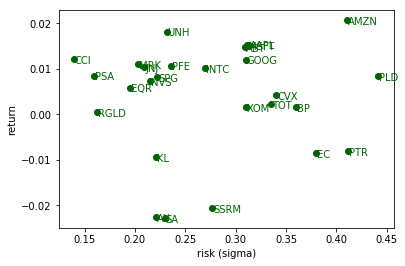

In [174]:
plot_stocks( np.sqrt(stock_covariance.diagonal() ), stock_return_mean,  stock_names )

# a. Use only stocks with positive beta. Rank excess return to beta ratio

In [175]:
Rf = 0.002
table = generate_table(stock_names, stock_info , stock_return_mean , Rf)
table

,stock name,alpha,beta,stock residue sigma square,(Ri-Rf)/beta,(Ri-Rf)*beta/residueSigmaSquare,betaSquare/residueSigmaSquare,COL2,COL4,Cstar
0,CCI,0.009123,0.405671,0.001743,0.025043,2.364309,94.411638,2.364309,94.411638,0.022799
1,UNH,0.013030,0.692769,0.001928,0.023405,5.826934,248.961522,8.191243,343.373159,0.023227
2,AMZN,0.011466,1.234159,0.004385,0.015154,5.264530,347.392347,13.455772,690.765506,0.019221
3,MRK,0.006499,0.603640,0.001914,0.014938,2.843497,190.356960,16.299270,881.122467,0.018305
4,AAPL,0.008368,0.933434,0.004284,0.014306,2.909740,203.391486,19.209010,1084.513952,0.017562
5,PSA,0.005058,0.465126,0.002217,0.014058,1.371730,97.575668,20.580740,1182.089620,0.017275
6,MSFT,0.008157,0.939234,0.002170,0.014039,5.706692,406.490855,26.287432,1588.580475,0.016452
7,ABT,0.007747,0.933624,0.001629,0.013639,7.300361,535.243415,33.587793,2123.823890,0.015746
8,JNJ,0.005652,0.630143,0.001070,0.013280,4.926820,370.997026,38.514613,2494.820916,0.015381
9,PFE,0.005399,0.712441,0.001229,0.012255,5.059146,412.835314,43.573759,2907.656230,0.014938


In [176]:
x_short = short_sale_okay(table , stock_names )

In [177]:
x_no_short = short_sale_Not_okay(table , stock_names )

In [184]:
x_short2 = short_sale_okay2( stock_covariance , stock_mean_return , Rf )


In [185]:
with_risk, with_return = risk_return(stock_covariance  , stock_mean_return , x_short )
without_risk, without_return = risk_return(stock_covariance  , stock_mean_return , x_no_short )

with_risk2, with_return2 = risk_return(stock_covariance  , stock_mean_return , x_short2 )


In [259]:

def plot_stocks_with_without( stock_risk , stock_mean_return , stocknamelist , with_risk, with_return, without_risk, without_return ):
        
    # (1) plot the (risk,return) for all the stocks
    xp = stock_risk
    yp = stock_mean_return
    plt.plot( xp , yp ,'o',color='darkgreen' )
    for i in range( len(xp) ):
        plt.annotate(  stocknamelist[i], (xp[i]+0.001, yp[i]-0.001) , color='darkgreen'   )
        
    plt.plot(  with_risk, with_return , 'o', color='red' )
    plt.annotate(  "with short sale", (with_risk+0.001, with_return-0.001) , color='red'   )
    plt.plot(  without_risk, without_return , 'o', color='blue' )
    plt.annotate(  "no short sale", (without_risk+0.001, without_return-0.001) , color='blue'   )
    
    plt.plot(  np.sqrt(market_sigma_square), market_return_mean , 'o', color='purple' )
    plt.annotate(  "market", (np.sqrt(market_sigma_square)+0.001, market_return_mean-0.001) , color='purple'   )

    
        
    plt.xlabel("risk (sigma)")
    plt.ylabel("return")
    plt.show()

# b. Find the composition of the point of tangency with and without short sales allowed

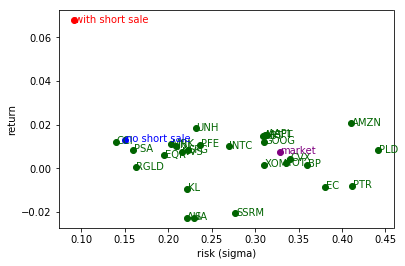

In [260]:
#plot_stocks(np.sqrt(stock_covariance.diagonal() ) , stock_return_mean, stock_names  )
plot_stocks_with_without( np.sqrt(stock_covariance.diagonal() ) , stock_mean_return , stock_names , with_risk2, with_return2, without_risk, without_return )


In [1]:
plot_stocks_without(np.sqrt(stock_covariance.diagonal() ) , stock_return_mean, stock_names  , x , y , x2 , y2 )

NameError: name 'plot_stocks_without' is not defined

In [218]:
def efficiency_frontier_no_short_sale( stock_names,stock_info ,stock_covariance, stock_return_mean , Rf):

    table0 = generate_table(stock_names, stock_info , stock_return_mean , Rf)
    x0 = short_sale_Not_okay( table0 , stock_names )
    return risk_return(stock_covariance  , stock_mean_return , x0)

def efficiency_frontier_yes_short_sale( stock_covariance , stock_mean_return ,  Rf):

    x0 = short_sale_okay2( stock_covariance , stock_mean_return , Rf )
    
    return risk_return(stock_covariance  , stock_mean_return , x0)

In [219]:
x = []
y = []
for i in range(100):
    a, b = efficiency_frontier_no_short_sale( stock_names,stock_info ,stock_covariance, stock_return_mean , 0.02/100*i)
    x.append(a)
    y.append(b)


In [265]:
x2 = []
y2 = []
for i in range(-1000,5,10):
    a, b = efficiency_frontier_yes_short_sale(stock_covariance , stock_mean_return , 0.02/100*i)
    x2.append(a)
    y2.append(b)

In [261]:
def plot_stocks_without( stock_risk , stock_mean_return , stocknamelist , x , y , x2, y2 ):
        
    # (1) plot the (risk,return) for all the stocks
    xp = stock_risk
    yp = stock_mean_return
    plt.plot( xp , yp ,'o',color='darkgreen' )
    for i in range( len(xp) ):
        plt.annotate(  stocknamelist[i], (xp[i]+0.001, yp[i]-0.001) , color='darkgreen'   )
        
    plt.plot(  x, y  , '.-', color='blue' )
    plt.annotate("short sale not allowed" , (x[0], y[0]+0.01) ,  color='blue' )
    plt.plot(  x2 , y2  , '.-', color='red' )
    plt.annotate("short sale allowed" , (x2[-1]+0.01, y2[-1]) ,  color='red' )


    plt.plot(  np.sqrt(market_sigma_square), market_return_mean , 'o', color='purple' )
    plt.annotate(  "market", (np.sqrt(market_sigma_square)+0.001, market_return_mean-0.001) , color='purple'   )

    
        
    plt.xlabel("risk (sigma)")
    plt.ylabel("return")
    plt.show()

# c. We want now to draw the efficient frontier when short sale are not allowed

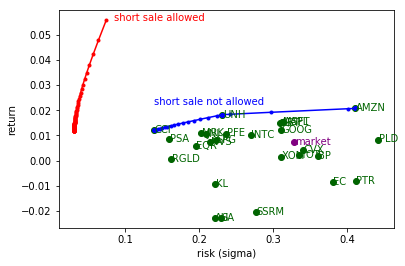

In [266]:
plot_stocks_without(np.sqrt(stock_covariance.diagonal() ) , stock_return_mean, stock_names  , x , y , x2 , y2 )